In [68]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import os
import music21 as m21
import pickle
from tensorflow.keras import layers
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
seed = 1339
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmp_h131ljh.ly'
Parsing...
Interpreting music...
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmp_h131ljh.ly.eps'...
Converting to PNG...
Layout output to `tmp_h131ljh.ly-1.eps'...
Writing tmp_h131ljh.ly-systems.texi...
Writing tmp_h131ljh.ly-systems.tex...
Writing tmp_h131ljh.ly-systems.count...
Success: compilation successfully completed


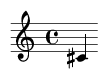

In [2]:
us = m21.environment.UserSettings()
us_path = us.getSettingsPath()
if not os.path.exists(us_path):
    us.create()
us['lilypondPath'] = '/home/mew/bin/lilypond'
n = m21.note.Note('C#')
n.show('ipython.lily.png')

Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmpbchcunun.ly'
Parsing...
Interpreting music...
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmpbchcunun.ly.eps'...
Converting to PNG...
Layout output to `tmpbchcunun.ly-1.eps'...
Writing tmpbchcunun.ly-systems.texi...
Writing tmpbchcunun.ly-systems.tex...
Writing tmpbchcunun.ly-systems.count...
Success: compilation successfully completed


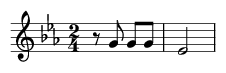

In [3]:
s = m21.stream.Stream()
s.append(m21.key.Key('E-'))
s.append(m21.meter.TimeSignature('2/4'))
s.append(m21.note.Rest(quarterLength=0.5))
s.append(m21.note.Note('g', quarterLength=0.5))
s.append(m21.note.Note('g', quarterLength=0.5))
s.append(m21.note.Note('g', quarterLength=0.5))
s.append(m21.note.Note('e-', quarterLength=2))

s.show('ipython.lily.png')

In [4]:
data_dir = pathlib.Path("./data/maestro-v3.0.0")
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1276


In [5]:
def play_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [6]:
pm = pretty_midi.PrettyMIDI(filenames[1])
play_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [7]:
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print(instrument_name)

Acoustic Grand Piano


In [8]:
instrument.notes[:10]

[Note(start=1.040625, end=1.106250, pitch=31, velocity=36),
 Note(start=1.032292, end=1.111458, pitch=43, velocity=43),
 Note(start=1.142708, end=1.216667, pitch=44, velocity=45),
 Note(start=1.144792, end=1.217708, pitch=32, velocity=35),
 Note(start=1.216667, end=1.287500, pitch=34, velocity=38),
 Note(start=1.208333, end=1.303125, pitch=46, velocity=55),
 Note(start=1.329167, end=1.955208, pitch=48, velocity=56),
 Note(start=1.332292, end=1.986458, pitch=36, velocity=39),
 Note(start=2.997917, end=4.764583, pitch=53, velocity=55),
 Note(start=3.010417, end=4.779167, pitch=56, velocity=66)]

In [9]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=31, note_name=G1, duration=0.0656
1: pitch=43, note_name=G2, duration=0.0792
2: pitch=44, note_name=G#2, duration=0.0740
3: pitch=32, note_name=G#1, duration=0.0729
4: pitch=34, note_name=A#1, duration=0.0708
5: pitch=46, note_name=A#2, duration=0.0948
6: pitch=48, note_name=C3, duration=0.6260
7: pitch=36, note_name=C2, duration=0.6542
8: pitch=53, note_name=F3, duration=1.7667
9: pitch=56, note_name=G#3, duration=1.7688


In [10]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [11]:
raw_notes = midi_to_notes(filenames[1])
raw_notes.head()

pitch     start       end      step  duration
0     43  1.032292  1.111458  0.000000  0.079167
1     31  1.040625  1.106250  0.008333  0.065625
2     44  1.142708  1.216667  0.102083  0.073958
3     32  1.144792  1.217708  0.002083  0.072917
4     46  1.208333  1.303125  0.063542  0.094792

In [12]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [13]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)
play_audio(example_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [54]:
num_files = 20
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)
all_notes

pitch       start         end      step  duration
0        71    1.092708    1.189583  0.000000  0.096875
1        55    1.279167    1.496875  0.186458  0.217708
2        71    1.288542    1.793750  0.009375  0.505208
3        59    1.463542    1.631250  0.175000  0.167708
4        62    1.633333    1.753125  0.169792  0.119792
...     ...         ...         ...       ...       ...
1355     60  337.768750  339.180208  2.131250  1.411458
1356     69  337.966667  339.080208  0.197917  1.113542
1357     45  340.552083  346.735417  2.585417  6.183333
1358     29  340.958333  347.304167  0.406250  6.345833
1359     53  340.962500  347.282292  0.004167  6.319792

[128022 rows x 5 columns]

In [55]:
train_notes = all_notes[['pitch', 'step','duration']]
train_notes

pitch      step  duration
0        71  0.000000  0.096875
1        55  0.186458  0.217708
2        71  0.009375  0.505208
3        59  0.175000  0.167708
4        62  0.169792  0.119792
...     ...       ...       ...
1355     60  2.131250  1.411458
1356     69  0.197917  1.113542
1357     45  2.585417  6.183333
1358     29  0.406250  6.345833
1359     53  0.004167  6.319792

[128022 rows x 3 columns]

create training data and labels
    

In [56]:
sample_length = 25 #should be tuned
vocab_size = 128

In [57]:
# for i in range(0,len(train_notes)-sample_length-1):
#     subsample = train_notes[i:i+sample_length+1].to_numpy().flatten()
#     subsample = np.reshape(subsample,(sample_length+1,3))
#     if i== 0:
#         Xtrain = subsample[np.newaxis,0:-1]/[vocab_size,1.0,1.0]
#         ytrain = subsample[np.newaxis,-1]
#     else:
#         Xtrain = np.vstack((Xtrain,subsample[np.newaxis,0:-1]/[vocab_size,1.0,1.0]))
#         ytrain = np.vstack((ytrain,subsample[np.newaxis,-1]))
# print(Xtrain.shape)
# print(ytrain.shape)

(127996, 25, 3)
(127996, 3)


In [69]:
# with open('Xtrain.pickle', 'wb') as f:
#     pickle.dump(Xtrain, f)
# with open('ytrain.pickle', 'wb') as f:
#     pickle.dump(ytrain, f)

In [70]:
with open('Xtrain.pickle') as f:
    Xtrain = pickle.load(f)
with open('ytrain.pickle') as f:
    ytrain = pickle.load(f)
    

In [60]:


input_shape = (sample_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = (tf.keras.layers.Dense(128, name='pitch')(x),tf.keras.layers.Dense(1, name='step')(x),tf.keras.layers.Dense(1, name='duration')(x))


model = tf.keras.Model(inputs, outputs)

loss = (tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError(),)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss,    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    }, optimizer=optimizer)

model.summary()



Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 25, 3)]      0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 25, 128)     34816       ['input_10[0][0]']               
 )                                                                                                
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 128)         98816       ['bidirectional_2[0][0]']        
 )                                                                                                
                                                                                            

In [61]:


model.fit(
    x=Xtrain,
    y=[ytrain[:,0],ytrain[:,1],ytrain[:,2]],
    batch_size=64,
    epochs=20,
    validation_split=0.1,
    shuffle=True
)



Epoch 1/20
1800/1800 [==============================] - 115s 61ms/step - loss: 0.3636 - pitch_loss: 4.0308 - step_loss: 0.0415 - duration_loss: 0.1206 - val_loss: 0.4184 - val_pitch_loss: 3.8167 - val_step_loss: 0.0588 - val_duration_loss: 0.1688
Epoch 2/20
1800/1800 [==============================] - 111s 62ms/step - loss: 0.3525 - pitch_loss: 3.9131 - step_loss: 0.0400 - duration_loss: 0.1168 - val_loss: 0.4111 - val_pitch_loss: 3.7879 - val_step_loss: 0.0560 - val_duration_loss: 0.1656
Epoch 3/20
1800/1800 [==============================] - 112s 62ms/step - loss: 0.3463 - pitch_loss: 3.8431 - step_loss: 0.0393 - duration_loss: 0.1149 - val_loss: 0.4038 - val_pitch_loss: 3.7515 - val_step_loss: 0.0543 - val_duration_loss: 0.1620
Epoch 4/20
1800/1800 [==============================] - 110s 61ms/step - loss: 0.3400 - pitch_loss: 3.7968 - step_loss: 0.0378 - duration_loss: 0.1124 - val_loss: 0.4162 - val_pitch_loss: 3.7668 - val_step_loss: 0.0597 - val_duration_loss: 0.1681
Epoch 5/20
1

In [66]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
"""Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
 # print(predictions)
  pitch_logits = predictions[0]
  step = predictions[1]
  duration = predictions[2]
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [63]:
temperature = 2.0
num_predictions = 120

key_order = ['pitch', 'step', 'duration']
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:sample_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions): #replace with predict for n seconds
    [pitch, step, duration] = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 2s 2s/step
(array([[-1.32422419e+01, -1.31575336e+01, -1.32563725e+01,
        -1.32316761e+01, -1.32879543e+01, -1.31757698e+01,
        -1.32056561e+01, -1.32683754e+01, -1.33330002e+01,
        -1.32159920e+01, -1.32609940e+01, -1.33147030e+01,
        -1.33236237e+01, -1.31989670e+01, -1.31892776e+01,
        -1.32531319e+01, -1.32708273e+01, -1.32634516e+01,
        -1.32462654e+01, -1.32794018e+01, -1.31418028e+01,
        -6.48474312e+00, -4.35378265e+00, -4.73436737e+00,
        -1.24100423e+00, -3.55098534e+00, -1.79244578e+00,
        -3.13111305e-01, -1.89756894e+00, -3.27649856e+00,
        -2.29757309e+00,  2.51234949e-01, -1.68432474e+00,
        -8.78559887e-01, -1.10738635e-01, -1.66349542e+00,
        -5.09397507e-01, -9.11510229e-01, -1.87138125e-01,
        -8.76421690e-01, -2.19388962e+00, -3.50022733e-01,
         5.21913350e-01, -2.74308503e-01,  3.72035772e-01,
        -3.90068680e-01, -1.03525960e+00, -1.17335653e+00,
     

1/1 [==============================] - 0s 22ms/step
(array([[-11.482719  , -11.181875  , -11.31506   , -11.376913  ,
        -11.425854  , -11.442729  , -11.363391  , -11.238097  ,
        -11.332462  , -11.432981  , -11.216726  , -11.19154   ,
        -11.289617  , -11.185661  , -11.240337  , -11.143163  ,
        -11.166126  , -11.434551  , -11.3696375 , -11.234651  ,
        -11.139194  ,  -3.599337  ,  -4.272616  ,  -1.2958347 ,
          2.1925507 ,  -1.2535497 ,  -0.6826198 ,   1.476968  ,
          0.6389965 ,   1.2289441 ,  -2.1591673 ,   0.5367912 ,
         -1.0489603 ,   2.504378  ,   0.30329025,  -2.3865757 ,
          1.8330814 ,  -1.6693618 ,  -0.4890991 ,  -0.77045983,
         -0.46392792,   0.38684824,  -0.8721308 ,  -3.2471552 ,
         -2.9816206 ,  -1.3304471 ,  -2.377819  ,  -4.4575615 ,
         -1.3486271 ,  -4.1427245 ,  -2.3935127 ,  -2.5488234 ,
         -2.392211  ,  -1.8310317 ,  -3.6625104 ,  -1.6938984 ,
         -2.6058207 ,  -2.7826545 ,  -2.2978206 ,  

1/1 [==============================] - 0s 21ms/step
(array([[-13.189038  , -12.9026985 , -12.932713  , -13.121198  ,
        -13.143793  , -13.105229  , -13.068225  , -12.864256  ,
        -12.918822  , -13.109432  , -12.773272  , -12.770435  ,
        -12.908851  , -12.900299  , -12.966169  , -12.821471  ,
        -12.789154  , -13.111313  , -12.943241  , -12.839289  ,
        -12.86261   ,  -3.5715334 ,  -6.083347  ,  -3.186639  ,
          0.26405513,  -1.7995293 ,  -1.8467573 ,   0.25279891,
         -0.93051994,   2.445719  ,  -5.1099453 ,  -1.0167322 ,
          0.54899883,   2.3944979 ,   1.2880068 ,  -4.9493637 ,
          1.8198498 ,  -2.5551276 ,  -0.31284213,   1.1437635 ,
         -2.9530811 ,   1.6262617 ,  -2.1921873 ,  -2.7267365 ,
         -1.683181  ,  -0.22838178,  -1.7730097 ,  -4.906055  ,
          0.45191157,  -2.9916842 ,  -0.70717084,  -0.8305704 ,
         -1.8427222 ,  -0.30841246,  -2.5636117 ,  -1.2638178 ,
         -1.9998889 ,  -0.56131476,  -1.8172317 ,  

1/1 [==============================] - 0s 26ms/step
(array([[-13.345894  , -13.036558  , -13.123556  , -13.332836  ,
        -13.269583  , -13.330023  , -13.247118  , -13.078737  ,
        -13.1279125 , -13.280149  , -12.979287  , -13.0068    ,
        -13.083351  , -13.037855  , -13.164974  , -13.0158615 ,
        -12.941819  , -13.319292  , -13.15639   , -13.035503  ,
        -13.026264  ,  -3.6243508 ,  -6.4153037 ,  -2.4071372 ,
         -0.7048508 ,  -0.70627415,  -1.6151602 ,   0.5132706 ,
         -1.9235656 ,   2.6617124 ,  -4.695399  ,  -1.2313262 ,
          0.39598498,   2.4525714 ,   0.30886555,  -3.4606733 ,
          0.88367057,  -2.7084608 ,  -0.87804157,   0.9941368 ,
         -1.457788  ,   1.550024  ,  -2.5904682 ,  -3.8027928 ,
         -1.8412058 ,  -0.770172  ,  -1.9018822 ,  -4.2267733 ,
          0.31523985,  -3.5548232 ,  -1.2061998 ,  -1.1442254 ,
         -1.9728312 ,  -1.054239  ,  -2.7966068 ,  -1.6264279 ,
         -2.16403   ,  -1.431112  ,  -1.5492256 ,  

1/1 [==============================] - 0s 22ms/step
(array([[-11.513741  , -11.24535   , -11.289124  , -11.484877  ,
        -11.4077215 , -11.480053  , -11.44042   , -11.278806  ,
        -11.285728  , -11.484897  , -11.193577  , -11.148144  ,
        -11.265642  , -11.254852  , -11.368657  , -11.204227  ,
        -11.12698   , -11.455248  , -11.342918  , -11.183104  ,
        -11.213962  ,  -2.6490061 ,  -5.81421   ,  -1.5832288 ,
         -0.4783653 ,  -0.82752204,  -1.9522533 ,  -0.97867095,
         -2.0895102 ,   2.014091  ,  -4.715063  ,  -1.7406019 ,
          0.09246606,   1.7611141 ,  -0.71864885,  -3.3103113 ,
          0.53884625,  -3.5197642 ,  -1.0339653 ,   0.59558547,
         -1.7731936 ,   1.6970279 ,  -2.8114595 ,  -3.6066396 ,
         -1.8895288 ,  -1.2120755 ,  -1.7295237 ,  -3.6820464 ,
         -0.24240616,  -3.4004521 ,  -1.0919226 ,  -1.1625667 ,
         -1.3795743 ,  -0.85164666,  -2.919201  ,  -1.7233834 ,
         -2.6984088 ,  -1.4095476 ,  -1.9227266 ,  

1/1 [==============================] - 0s 25ms/step
(array([[-11.893253  , -11.607933  , -11.668281  , -11.851234  ,
        -11.736498  , -11.900071  , -11.791323  , -11.618484  ,
        -11.678764  , -11.859673  , -11.524601  , -11.486876  ,
        -11.628843  , -11.5874195 , -11.751814  , -11.567025  ,
        -11.521895  , -11.816399  , -11.704944  , -11.573286  ,
        -11.561263  ,  -2.9579935 ,  -5.516696  ,  -2.214086  ,
         -1.0801731 ,  -1.8510586 ,  -2.165378  ,  -1.2319331 ,
         -1.7685599 ,   1.3221588 ,  -4.3765335 ,  -2.084641  ,
         -0.30982122,   1.3093035 ,  -1.1820362 ,  -3.264317  ,
          0.3383665 ,  -2.8885043 ,  -1.3680651 ,  -0.02480568,
         -1.8216302 ,   1.1331165 ,  -3.0229325 ,  -3.8826165 ,
         -1.9626937 ,  -1.6481841 ,  -2.556133  ,  -4.0073004 ,
         -0.7612194 ,  -3.9680488 ,  -2.2224023 ,  -1.9930425 ,
         -1.6298218 ,  -1.2360003 ,  -2.8811727 ,  -2.121784  ,
         -1.9965134 ,  -2.00256   ,  -2.046945  ,  

1/1 [==============================] - 0s 27ms/step
(array([[-10.674894  , -10.426346  , -10.44158   , -10.698986  ,
        -10.523492  , -10.766343  , -10.620686  , -10.540012  ,
        -10.490762  , -10.619747  , -10.49847   , -10.398112  ,
        -10.550705  , -10.52677   , -10.500719  , -10.45866   ,
        -10.344604  , -10.701843  , -10.661585  , -10.459705  ,
        -10.330948  ,  -1.9709389 ,  -4.3968945 ,  -0.1981858 ,
         -1.804173  ,  -0.6539454 ,  -1.8797355 ,   0.32232606,
         -0.5253977 ,  -0.7884444 ,  -5.1908026 ,  -0.5024113 ,
         -1.914723  ,   2.04854   ,  -2.3875847 ,  -2.4979472 ,
          3.1399307 ,  -4.490782  ,  -0.46834528,   0.52342343,
         -0.7579349 ,   1.7513142 ,  -2.4202487 ,  -3.7294989 ,
         -2.2647953 ,  -2.7071698 ,  -1.9851089 ,  -5.610226  ,
         -0.6843729 ,  -3.360278  ,  -1.4126855 ,  -0.6833964 ,
         -1.5449903 ,  -0.04182291,  -2.3024259 ,  -1.5408573 ,
         -1.2571731 ,  -2.203304  ,  -3.4639282 ,  

1/1 [==============================] - 0s 25ms/step
(array([[-1.05066929e+01, -1.02213945e+01, -1.03303099e+01,
        -1.03892107e+01, -1.04547234e+01, -1.04747334e+01,
        -1.03996239e+01, -1.01811638e+01, -1.02947674e+01,
        -1.05104742e+01, -1.01704235e+01, -1.01513939e+01,
        -1.02228994e+01, -1.01600952e+01, -1.03369455e+01,
        -1.00965567e+01, -1.01234446e+01, -1.03798752e+01,
        -1.03424025e+01, -1.01277151e+01, -1.01356583e+01,
        -3.54041481e+00, -7.95628977e+00, -1.59106898e+00,
        -1.68696547e+00, -2.47807360e+00, -4.08017540e+00,
        -2.21464825e+00, -4.10104513e+00,  2.95063615e+00,
        -5.72848034e+00, -4.29576492e+00, -4.98820275e-01,
         5.28739452e-01, -1.61948133e+00, -3.46407175e+00,
        -1.59580576e+00, -2.58158660e+00, -3.25396466e+00,
         2.24007547e-01, -1.68610072e+00, -9.96270478e-02,
        -3.41416645e+00, -4.36598206e+00, -3.54979610e+00,
        -1.70214057e+00, -2.25819540e+00, -2.65914416e+00,
   

1/1 [==============================] - 0s 20ms/step
(array([[-10.346715  , -10.061526  , -10.170117  , -10.214735  ,
        -10.2933655 , -10.320543  , -10.240686  , -10.015347  ,
        -10.145949  , -10.346426  ,  -9.996893  ,  -9.981243  ,
        -10.058304  ,  -9.9961195 , -10.166653  ,  -9.924897  ,
         -9.967392  , -10.210507  , -10.186882  ,  -9.979584  ,
         -9.965995  ,  -3.5618482 ,  -7.678052  ,  -1.4665306 ,
         -1.4347852 ,  -2.5379944 ,  -3.9347787 ,  -1.9827572 ,
         -3.8796234 ,   2.8866255 ,  -5.6321926 ,  -4.1485653 ,
         -0.5802592 ,   0.69731116,  -1.5502219 ,  -3.3212085 ,
         -1.3670429 ,  -2.3267415 ,  -3.2062743 ,   0.1705879 ,
         -1.4387693 ,  -0.14509106,  -3.314095  ,  -4.3085823 ,
         -3.5788074 ,  -1.8159792 ,  -2.2829876 ,  -2.8447793 ,
         -2.056868  ,  -3.4664042 ,  -2.2049105 ,  -2.4876018 ,
         -0.99622756,  -2.113451  ,  -4.2839384 ,  -2.5537424 ,
         -4.3206944 ,  -3.156422  ,  -2.3931973 ,  

1/1 [==============================] - 0s 29ms/step
(array([[-1.08525982e+01, -1.05936489e+01, -1.06689806e+01,
        -1.07588778e+01, -1.08253975e+01, -1.08166237e+01,
        -1.07591019e+01, -1.05610218e+01, -1.06345377e+01,
        -1.08582458e+01, -1.05530205e+01, -1.05261078e+01,
        -1.05926008e+01, -1.05319080e+01, -1.07025576e+01,
        -1.04674006e+01, -1.05042620e+01, -1.07565374e+01,
        -1.06870670e+01, -1.04651041e+01, -1.05328255e+01,
        -3.66643047e+00, -8.24297428e+00, -1.81422973e+00,
        -1.65528798e+00, -2.20527244e+00, -4.23491716e+00,
        -2.58452940e+00, -4.25833845e+00,  2.91719675e+00,
        -5.91906166e+00, -4.43828678e+00, -2.90988952e-01,
         3.48789930e-01, -1.64741683e+00, -3.68913364e+00,
        -1.68167889e+00, -3.29805136e+00, -3.22295856e+00,
         4.62996662e-01, -1.96393406e+00,  1.88416466e-01,
        -3.48074365e+00, -4.24491501e+00, -3.28741598e+00,
        -1.58413959e+00, -1.87573957e+00, -2.41989970e+00,
   

1/1 [==============================] - 0s 20ms/step
(array([[-10.437114  , -10.1324    , -10.224518  , -10.336004  ,
        -10.404278  , -10.373802  , -10.325881  , -10.126682  ,
        -10.211988  , -10.4358425 , -10.1083145 , -10.068619  ,
        -10.154067  , -10.113507  , -10.288325  , -10.025672  ,
        -10.059653  , -10.298155  , -10.257836  , -10.036152  ,
        -10.08522   ,  -3.0973415 ,  -7.831522  ,  -1.1752627 ,
         -1.4647133 ,  -1.9358765 ,  -3.8049293 ,  -2.417021  ,
         -4.207476  ,   3.2723475 ,  -6.056743  ,  -4.224225  ,
         -0.37107006,   0.428007  ,  -1.5736985 ,  -3.681994  ,
         -1.5412433 ,  -3.170847  ,  -3.3340986 ,   0.44974956,
         -1.9048823 ,   0.05710343,  -3.4841602 ,  -4.121876  ,
         -3.359002  ,  -1.5638791 ,  -1.8141155 ,  -2.381662  ,
         -1.645674  ,  -3.1410954 ,  -1.4074161 ,  -1.6815362 ,
         -0.5236125 ,  -1.905984  ,  -4.1765184 ,  -2.349459  ,
         -4.672136  ,  -2.5491798 ,  -2.1107712 ,  

1/1 [==============================] - 0s 26ms/step
(array([[-10.473347  , -10.184789  , -10.289688  , -10.347043  ,
        -10.420701  , -10.447623  , -10.36778   , -10.141285  ,
        -10.266698  , -10.474353  , -10.125099  , -10.108761  ,
        -10.183126  , -10.125921  , -10.300515  , -10.052241  ,
        -10.093869  , -10.335913  , -10.312694  , -10.105815  ,
        -10.093174  ,  -3.578559  ,  -7.8260245 ,  -1.5368686 ,
         -1.5451319 ,  -2.5453484 ,  -3.9897423 ,  -2.0676668 ,
         -4.021388  ,   2.8706734 ,  -5.763376  ,  -4.217968  ,
         -0.5698063 ,   0.58823323,  -1.6254203 ,  -3.429288  ,
         -1.4301819 ,  -2.4617395 ,  -3.2785413 ,   0.20129839,
         -1.5466442 ,  -0.19025531,  -3.3841665 ,  -4.2859554 ,
         -3.5622675 ,  -1.7797843 ,  -2.2796102 ,  -2.7325122 ,
         -1.9644101 ,  -3.4082341 ,  -2.095341  ,  -2.3573997 ,
         -0.877333  ,  -2.091949  ,  -4.193329  ,  -2.5007293 ,
         -4.325219  ,  -3.0699792 ,  -2.3330357 ,  

1/1 [==============================] - 0s 25ms/step
(array([[-10.313442  , -10.029523  , -10.140323  , -10.174051  ,
        -10.258116  , -10.289491  , -10.207249  ,  -9.97936   ,
        -10.115786  , -10.310901  ,  -9.962378  ,  -9.949484  ,
        -10.026534  ,  -9.95801   , -10.128258  ,  -9.887923  ,
         -9.934236  , -10.176462  , -10.1560135 ,  -9.94862   ,
         -9.928972  ,  -3.6204865 ,  -7.6411204 ,  -1.4336311 ,
         -1.3640745 ,  -2.571302  ,  -3.9572163 ,  -1.9147896 ,
         -3.8476887 ,   2.8730268 ,  -5.570009  ,  -4.1319914 ,
         -0.6064392 ,   0.7427057 ,  -1.521327  ,  -3.2626486 ,
         -1.3446162 ,  -2.2402654 ,  -3.226032  ,   0.14285088,
         -1.3775592 ,  -0.17775911,  -3.277632  ,  -4.3142614 ,
         -3.6208463 ,  -1.8558623 ,  -2.3062558 ,  -2.892098  ,
         -2.128933  ,  -3.5154579 ,  -2.3155496 ,  -2.5897145 ,
         -1.0602326 ,  -2.1659293 ,  -4.3529253 ,  -2.5963962 ,
         -4.341852  ,  -3.2647927 ,  -2.4417908 ,  

1/1 [==============================] - 0s 23ms/step
(array([[-10.47232   , -10.1925745 , -10.294233  , -10.339333  ,
        -10.419556  , -10.454182  , -10.366774  , -10.1403    ,
        -10.2722435 , -10.47249   , -10.119354  , -10.10874   ,
        -10.184233  , -10.122706  , -10.290961  , -10.047726  ,
        -10.097642  , -10.336994  , -10.316201  , -10.111564  ,
        -10.090842  ,  -3.681314  ,  -7.7538924 ,  -1.5394164 ,
         -1.4578825 ,  -2.6327286 ,  -4.001096  ,  -1.9522146 ,
         -3.910409  ,   2.781033  ,  -5.691915  ,  -4.198767  ,
         -0.6007024 ,   0.65178   ,  -1.5992966 ,  -3.3306432 ,
         -1.3392272 ,  -2.2982125 ,  -3.261711  ,   0.17648172,
         -1.4585706 ,  -0.18992248,  -3.328672  ,  -4.301653  ,
         -3.5813818 ,  -1.8810239 ,  -2.297433  ,  -2.877167  ,
         -2.0777183 ,  -3.4624994 ,  -2.2844617 ,  -2.4836879 ,
         -1.0357351 ,  -2.1448684 ,  -4.311716  ,  -2.579432  ,
         -4.281296  ,  -3.2309337 ,  -2.422963  ,  

1/1 [==============================] - 0s 22ms/step
(array([[-10.370373  , -10.090913  , -10.1982765 , -10.231909  ,
        -10.316846  , -10.348922  , -10.264839  , -10.036775  ,
        -10.174239  , -10.369576  , -10.016876  , -10.004812  ,
        -10.081462  , -10.017113  , -10.186084  ,  -9.946078  ,
         -9.994884  , -10.23413   , -10.212225  , -10.008859  ,
         -9.988139  ,  -3.648677  ,  -7.648586  ,  -1.480428  ,
         -1.3814933 ,  -2.6064177 ,  -3.9619274 ,  -1.9225677 ,
         -3.825613  ,   2.8455296 ,  -5.5812674 ,  -4.1590567 ,
         -0.6001916 ,   0.72456026,  -1.5132041 ,  -3.2748795 ,
         -1.3327324 ,  -2.2090743 ,  -3.215736  ,   0.13210562,
         -1.3869009 ,  -0.1713664 ,  -3.285596  ,  -4.311138  ,
         -3.605112  ,  -1.8604876 ,  -2.323215  ,  -2.9167376 ,
         -2.1342766 ,  -3.5121875 ,  -2.3408775 ,  -2.5947318 ,
         -1.0927458 ,  -2.1600423 ,  -4.345782  ,  -2.6079776 ,
         -4.291737  ,  -3.2595007 ,  -2.4308093 ,  

1/1 [==============================] - 0s 22ms/step
(array([[-10.470998  , -10.173593  , -10.25761   , -10.3438425 ,
        -10.4319725 , -10.425285  , -10.355073  , -10.145292  ,
        -10.240552  , -10.47056   , -10.124048  , -10.101713  ,
        -10.183698  , -10.135821  , -10.298114  , -10.028422  ,
        -10.071441  , -10.31907   , -10.298456  , -10.060386  ,
        -10.106755  ,  -3.3390808 ,  -8.098259  ,  -1.220061  ,
         -1.577428  ,  -2.0810752 ,  -3.9112816 ,  -2.0844889 ,
         -4.3513303 ,   2.9504726 ,  -6.1204762 ,  -4.360699  ,
         -0.218239  ,   0.33917058,  -1.7738032 ,  -3.7156668 ,
         -1.608661  ,  -3.0608711 ,  -3.636164  ,   0.6530743 ,
         -2.0765853 ,  -0.07842134,  -3.431069  ,  -4.180646  ,
         -3.3097086 ,  -1.8784883 ,  -1.89838   ,  -2.435811  ,
         -1.7307296 ,  -3.0873973 ,  -1.7229708 ,  -1.5689671 ,
         -0.7036969 ,  -2.0893223 ,  -4.50701   ,  -2.527531  ,
         -4.827019  ,  -2.8452303 ,  -2.3048408 ,  

1/1 [==============================] - 0s 28ms/step
(array([[-10.5028515 , -10.219533  , -10.303047  , -10.412578  ,
        -10.474503  , -10.448759  , -10.395987  , -10.203306  ,
        -10.284337  , -10.513402  , -10.1814    , -10.139944  ,
        -10.224149  , -10.186665  , -10.347284  , -10.104374  ,
        -10.131368  , -10.38007   , -10.326037  , -10.110266  ,
        -10.166691  ,  -3.173739  ,  -7.809301  ,  -1.216658  ,
         -1.5773492 ,  -2.0041642 ,  -3.8750958 ,  -2.2795823 ,
         -4.0054502 ,   3.297197  ,  -6.0347233 ,  -4.238753  ,
         -0.23698084,   0.4490043 ,  -1.5087299 ,  -3.7090511 ,
         -1.4658804 ,  -3.3011355 ,  -3.221123  ,   0.4492425 ,
         -1.8752743 ,   0.15046309,  -3.4789298 ,  -4.2120857 ,
         -3.3996248 ,  -1.5675696 ,  -1.8565896 ,  -2.5043051 ,
         -1.6532545 ,  -3.2231069 ,  -1.444223  ,  -1.8101332 ,
         -0.74910647,  -1.9463705 ,  -4.261118  ,  -2.418569  ,
         -4.8093796 ,  -2.5593135 ,  -2.2274559 ,  

1/1 [==============================] - 0s 19ms/step
(array([[-10.513858  , -10.235082  , -10.333569  , -10.392044  ,
        -10.464305  , -10.493943  , -10.409563  , -10.188209  ,
        -10.310915  , -10.51744   , -10.167352  , -10.153701  ,
        -10.228256  , -10.170424  , -10.337509  , -10.097266  ,
        -10.140239  , -10.383474  , -10.357695  , -10.151865  ,
        -10.139679  ,  -3.6451697 ,  -7.8263106 ,  -1.5608826 ,
         -1.5463138 ,  -2.579956  ,  -4.023306  ,  -2.0019786 ,
         -3.957367  ,   2.8385906 ,  -5.761254  ,  -4.2046676 ,
         -0.5621846 ,   0.60740554,  -1.6157244 ,  -3.3969822 ,
         -1.3575994 ,  -2.467685  ,  -3.2339919 ,   0.20990172,
         -1.5233135 ,  -0.14679417,  -3.361944  ,  -4.300065  ,
         -3.5661402 ,  -1.8303633 ,  -2.2401843 ,  -2.8148751 ,
         -1.9813557 ,  -3.411972  ,  -2.134332  ,  -2.386157  ,
         -0.9816173 ,  -2.0917056 ,  -4.2549334 ,  -2.5244198 ,
         -4.3355913 ,  -3.1145988 ,  -2.3924959 ,  

1/1 [==============================] - 0s 18ms/step
(array([[-10.453996  , -10.175178  , -10.276668  , -10.322978  ,
        -10.402781  , -10.435421  , -10.349154  , -10.123015  ,
        -10.255502  , -10.455172  , -10.100769  , -10.089991  ,
        -10.165862  , -10.105033  , -10.272949  , -10.030965  ,
        -10.081242  , -10.318976  , -10.297579  , -10.094726  ,
        -10.073686  ,  -3.6713257 ,  -7.7288575 ,  -1.5291331 ,
         -1.4353908 ,  -2.6268666 ,  -3.9914508 ,  -1.9489484 ,
         -3.8865738 ,   2.825745  ,  -5.6811566 ,  -4.18501   ,
         -0.59710395,   0.6685995 ,  -1.5675131 ,  -3.3199124 ,
         -1.3194604 ,  -2.282013  ,  -3.2363815 ,   0.16918918,
         -1.4357119 ,  -0.17393932,  -3.3217795 ,  -4.2951274 ,
         -3.588019  ,  -1.8669046 ,  -2.280666  ,  -2.8814986 ,
         -2.0741313 ,  -3.4659607 ,  -2.2826643 ,  -2.5005388 ,
         -1.0526457 ,  -2.138974  ,  -4.314464  ,  -2.5738938 ,
         -4.2791166 ,  -3.2324374 ,  -2.4217436 ,  

1/1 [==============================] - 0s 21ms/step
(array([[-10.454893  , -10.175507  , -10.275471  , -10.324586  ,
        -10.4039755 , -10.435724  , -10.350636  , -10.124728  ,
        -10.255917  , -10.456383  , -10.10218   , -10.089546  ,
        -10.166399  , -10.108391  , -10.274429  , -10.031759  ,
        -10.081383  , -10.319693  , -10.298059  , -10.095508  ,
        -10.075886  ,  -3.64719   ,  -7.712933  ,  -1.4986331 ,
         -1.4261187 ,  -2.5978787 ,  -3.973508  ,  -1.9322467 ,
         -3.862053  ,   2.815605  ,  -5.707063  ,  -4.169336  ,
         -0.58570606,   0.66921663,  -1.5727711 ,  -3.3363867 ,
         -1.2864412 ,  -2.3238251 ,  -3.2379997 ,   0.18604854,
         -1.4367137 ,  -0.1612547 ,  -3.322787  ,  -4.288297  ,
         -3.5761256 ,  -1.872238  ,  -2.2682197 ,  -2.8976116 ,
         -2.0652444 ,  -3.4756885 ,  -2.2746525 ,  -2.4707234 ,
         -1.0635831 ,  -2.1409879 ,  -4.328215  ,  -2.5751166 ,
         -4.29012   ,  -3.2304764 ,  -2.4387827 ,  

1/1 [==============================] - 0s 28ms/step
(array([[-10.427001  , -10.149133  , -10.251291  , -10.293034  ,
        -10.37572   , -10.407259  , -10.3221245 , -10.095281  ,
        -10.229704  , -10.428362  , -10.072222  , -10.060221  ,
        -10.136755  , -10.078008  , -10.24495   , -10.003114  ,
        -10.053462  , -10.290786  , -10.268488  , -10.067017  ,
        -10.047299  ,  -3.646527  ,  -7.678892  ,  -1.5114927 ,
         -1.4156315 ,  -2.6087663 ,  -3.9559731 ,  -1.9301561 ,
         -3.8358383 ,   2.827156  ,  -5.648959  ,  -4.177411  ,
         -0.5765059 ,   0.68425393,  -1.5386963 ,  -3.3218055 ,
         -1.3150985 ,  -2.259502  ,  -3.227139  ,   0.1618545 ,
         -1.4296827 ,  -0.16012454,  -3.3122318 ,  -4.2992945 ,
         -3.5738149 ,  -1.8676264 ,  -2.303862  ,  -2.9083517 ,
         -2.09199   ,  -3.4848437 ,  -2.3134477 ,  -2.5190778 ,
         -1.0907955 ,  -2.1507456 ,  -4.3321743 ,  -2.5968206 ,
         -4.270792  ,  -3.2331307 ,  -2.424781  ,  

1/1 [==============================] - 0s 26ms/step
(array([[-10.782135  , -10.525763  , -10.602372  , -10.682315  ,
        -10.757658  , -10.749893  , -10.693889  , -10.487788  ,
        -10.572357  , -10.787794  , -10.475201  , -10.451838  ,
        -10.520505  , -10.459368  , -10.629204  , -10.392442  ,
        -10.4397955 , -10.681724  , -10.617828  , -10.403026  ,
        -10.46019   ,  -3.7108283 ,  -8.11914   ,  -1.7423229 ,
         -1.4390589 ,  -2.2157927 ,  -4.1983232 ,  -2.4771566 ,
         -4.1192927 ,   2.9454267 ,  -5.8169427 ,  -4.371156  ,
         -0.31537074,   0.4457705 ,  -1.5441122 ,  -3.5847154 ,
         -1.5278329 ,  -3.0736966 ,  -3.186554  ,   0.4323589 ,
         -1.7994161 ,   0.20260958,  -3.3982768 ,  -4.2103515 ,
         -3.3030713 ,  -1.6124268 ,  -1.8582947 ,  -2.533927  ,
         -1.6565394 ,  -3.1778276 ,  -1.5334289 ,  -1.9214435 ,
         -0.7536829 ,  -1.8965291 ,  -4.1406283 ,  -2.4511817 ,
         -4.46119   ,  -2.6063635 ,  -2.1536703 ,  

1/1 [==============================] - 0s 22ms/step
(array([[-10.450803  , -10.158821  , -10.259481  , -10.33158   ,
        -10.404486  , -10.418985  , -10.351165  , -10.123231  ,
        -10.245186  , -10.450265  , -10.102734  , -10.084782  ,
        -10.1623535 , -10.112216  , -10.286708  , -10.034328  ,
        -10.076691  , -10.310803  , -10.289429  , -10.084569  ,
        -10.076677  ,  -3.5030289 ,  -7.791854  ,  -1.4687612 ,
         -1.3925098 ,  -2.3993604 ,  -3.9209309 ,  -2.1221476 ,
         -4.0308003 ,   2.937467  ,  -5.809502  ,  -4.13039   ,
         -0.57655716,   0.6310637 ,  -1.5584056 ,  -3.4122849 ,
         -1.3227165 ,  -2.4774735 ,  -3.2103555 ,   0.2703864 ,
         -1.5132937 ,  -0.08996096,  -3.345845  ,  -4.1628046 ,
         -3.4703403 ,  -1.7318248 ,  -2.1053843 ,  -2.7068408 ,
         -1.8518584 ,  -3.3442976 ,  -1.9664208 ,  -2.2158182 ,
         -0.8282822 ,  -1.991063  ,  -4.1615844 ,  -2.4241168 ,
         -4.226995  ,  -3.0065691 ,  -2.277237  ,  

1/1 [==============================] - 0s 21ms/step
(array([[-1.04263735e+01, -1.01047354e+01, -1.02104540e+01,
        -1.03133307e+01, -1.03734856e+01, -1.03716049e+01,
        -1.03254757e+01, -1.00909338e+01, -1.02049341e+01,
        -1.04127817e+01, -1.00746851e+01, -1.00519686e+01,
        -1.01279173e+01, -1.00895262e+01, -1.02816105e+01,
        -1.00090685e+01, -1.00375423e+01, -1.02701864e+01,
        -1.02555752e+01, -1.00410185e+01, -1.00444956e+01,
        -3.23058414e+00, -7.94287395e+00, -1.43471384e+00,
        -1.41505289e+00, -2.12290478e+00, -3.84598970e+00,
        -2.41010356e+00, -4.35062313e+00,  3.10258746e+00,
        -6.06067228e+00, -4.03266144e+00, -5.97305477e-01,
         6.09321833e-01, -1.59884143e+00, -3.54967546e+00,
        -1.35345650e+00, -2.63288879e+00, -3.24352074e+00,
         4.10633057e-01, -1.66361904e+00, -5.80474734e-03,
        -3.41237187e+00, -4.01993608e+00, -3.32227015e+00,
        -1.54025245e+00, -1.94618797e+00, -2.44910312e+00,
   

1/1 [==============================] - 0s 22ms/step
(array([[-10.496471  , -10.211048  , -10.31245   , -10.373233  ,
        -10.44569   , -10.474077  , -10.395698  , -10.167714  ,
        -10.292681  , -10.496708  , -10.149276  , -10.136082  ,
        -10.210335  , -10.15261   , -10.325407  , -10.078306  ,
        -10.122323  , -10.3617525 , -10.339879  , -10.134935  ,
        -10.11761   ,  -3.610817  ,  -7.80963   ,  -1.5445498 ,
         -1.453983  ,  -2.5465581 ,  -4.0015545 ,  -2.045275  ,
         -3.9967723 ,   2.840152  ,  -5.753683  ,  -4.169022  ,
         -0.603754  ,   0.62916064,  -1.5964036 ,  -3.3746166 ,
         -1.3375691 ,  -2.418408  ,  -3.2375214 ,   0.22212207,
         -1.5013885 ,  -0.14825794,  -3.3500314 ,  -4.2424436 ,
         -3.540445  ,  -1.80441   ,  -2.21347   ,  -2.7793965 ,
         -1.947762  ,  -3.4013197 ,  -2.1103084 ,  -2.354059  ,
         -0.9049812 ,  -2.0626702 ,  -4.200032  ,  -2.4912019 ,
         -4.253587  ,  -3.1207864 ,  -2.353915  ,  

1/1 [==============================] - 0s 22ms/step
(array([[-10.5885725 , -10.31244   , -10.408609  , -10.464111  ,
        -10.538603  , -10.569729  , -10.490223  , -10.262921  ,
        -10.386029  , -10.589006  , -10.247405  , -10.235373  ,
        -10.306529  , -10.246005  , -10.417124  , -10.174     ,
        -10.218839  , -10.461512  , -10.4337015 , -10.228098  ,
        -10.216063  ,  -3.7091942 ,  -7.892942  ,  -1.6406302 ,
         -1.4667943 ,  -2.577819  ,  -4.096438  ,  -2.0625458 ,
         -4.007538  ,   2.7764356 ,  -5.748835  ,  -4.2141924 ,
         -0.5766258 ,   0.6145699 ,  -1.5966543 ,  -3.386701  ,
         -1.3657708 ,  -2.461349  ,  -3.2507117 ,   0.24289429,
         -1.5288724 ,  -0.12248453,  -3.347686  ,  -4.2680902 ,
         -3.527867  ,  -1.8261034 ,  -2.2213755 ,  -2.7995632 ,
         -1.9569492 ,  -3.4110763 ,  -2.124404  ,  -2.371039  ,
         -0.94600993,  -2.084359  ,  -4.2175207 ,  -2.535061  ,
         -4.276843  ,  -3.134271  ,  -2.3755465 ,  

1/1 [==============================] - 0s 23ms/step
(array([[-10.599165  , -10.312424  , -10.413282  , -10.490476  ,
        -10.548179  , -10.571494  , -10.493004  , -10.27796   ,
        -10.384092  , -10.6045685 , -10.264042  , -10.244526  ,
        -10.316952  , -10.261339  , -10.4319725 , -10.191689  ,
        -10.217106  , -10.47353   , -10.440386  , -10.22508   ,
        -10.231359  ,  -3.557026  ,  -8.038137  ,  -1.6089454 ,
         -1.7971373 ,  -2.4797404 ,  -4.0832863 ,  -2.1879287 ,
         -4.146966  ,   2.85576   ,  -5.900275  ,  -4.27085   ,
         -0.5235334 ,   0.46550095,  -1.7383946 ,  -3.538495  ,
         -1.509998  ,  -2.7554681 ,  -3.2635167 ,   0.2755047 ,
         -1.7151204 ,  -0.11698794,  -3.441603  ,  -4.3127    ,
         -3.518248  ,  -1.7239923 ,  -2.1926513 ,  -2.6419177 ,
         -1.8275611 ,  -3.2976959 ,  -1.8073627 ,  -2.1709661 ,
         -0.7404017 ,  -1.9694258 ,  -4.0958447 ,  -2.4171026 ,
         -4.4371195 ,  -2.8495545 ,  -2.28793   ,  

1/1 [==============================] - 0s 23ms/step
(array([[-10.4783535 , -10.185235  , -10.281149  , -10.31988   ,
        -10.419725  , -10.468846  , -10.36106   , -10.129772  ,
        -10.263091  , -10.472399  , -10.107545  , -10.112224  ,
        -10.187412  , -10.118772  , -10.280721  , -10.013832  ,
        -10.078205  , -10.319643  , -10.329444  , -10.098912  ,
        -10.07653   ,  -3.7947469 ,  -8.076229  ,  -1.5101972 ,
         -1.6060455 ,  -2.6823497 ,  -4.0301476 ,  -1.7443027 ,
         -4.277723  ,   2.4337423 ,  -5.9112167 ,  -4.3488016 ,
         -0.5492929 ,   0.43557835,  -1.9656801 ,  -3.443397  ,
         -1.5026636 ,  -2.3298407 ,  -3.7177901 ,   0.42075753,
         -1.7479328 ,  -0.43502855,  -3.3314767 ,  -4.269119  ,
         -3.4964938 ,  -2.2071667 ,  -2.2794685 ,  -2.7527342 ,
         -2.0902014 ,  -3.2624316 ,  -2.4368246 ,  -2.09969   ,
         -0.9532319 ,  -2.2985497 ,  -4.566683  ,  -2.6638398 ,
         -4.429101  ,  -3.444758  ,  -2.520376  ,  

1/1 [==============================] - 0s 21ms/step
(array([[-10.529251  , -10.250618  , -10.351601  , -10.399597  ,
        -10.480526  , -10.507234  , -10.421759  , -10.196691  ,
        -10.3264885 , -10.531683  , -10.176737  , -10.165383  ,
        -10.239231  , -10.178642  , -10.351629  , -10.106432  ,
        -10.155933  , -10.393677  , -10.368162  , -10.163327  ,
        -10.151884  ,  -3.7025754 ,  -7.882563  ,  -1.5965497 ,
         -1.5331781 ,  -2.6373918 ,  -4.0609274 ,  -2.0860603 ,
         -4.0333223 ,   2.8721418 ,  -5.738318  ,  -4.308451  ,
         -0.55491626,   0.5795622 ,  -1.593996  ,  -3.3887806 ,
         -1.4732544 ,  -2.34513   ,  -3.2937462 ,   0.18146566,
         -1.540497  ,  -0.19552392,  -3.374104  ,  -4.307604  ,
         -3.585966  ,  -1.8175603 ,  -2.2780385 ,  -2.761215  ,
         -2.048527  ,  -3.4130683 ,  -2.1887307 ,  -2.4481268 ,
         -0.95962805,  -2.1260774 ,  -4.2827563 ,  -2.5605626 ,
         -4.344697  ,  -3.1339142 ,  -2.340228  ,  

1/1 [==============================] - 0s 21ms/step
(array([[-10.465239  , -10.185496  , -10.286434  , -10.33281   ,
        -10.413034  , -10.445467  , -10.361393  , -10.132211  ,
        -10.265865  , -10.465044  , -10.109663  , -10.099932  ,
        -10.174139  , -10.116088  , -10.285687  , -10.041923  ,
        -10.091191  , -10.3271885 , -10.307283  , -10.10512   ,
        -10.084293  ,  -3.6708703 ,  -7.7404327 ,  -1.5559683 ,
         -1.4411778 ,  -2.6124744 ,  -3.976253  ,  -1.962147  ,
         -3.9305735 ,   2.8281484 ,  -5.693804  ,  -4.175783  ,
         -0.57015914,   0.6766677 ,  -1.5566957 ,  -3.341868  ,
         -1.338423  ,  -2.2934668 ,  -3.223273  ,   0.18246147,
         -1.4481972 ,  -0.17325664,  -3.3258286 ,  -4.2659373 ,
         -3.554886  ,  -1.8317109 ,  -2.287863  ,  -2.827923  ,
         -2.0051763 ,  -3.4482431 ,  -2.2439356 ,  -2.4549148 ,
         -1.0229688 ,  -2.1226096 ,  -4.2645216 ,  -2.54245   ,
         -4.2387214 ,  -3.1768885 ,  -2.3783243 ,  

In [64]:
generated_notes

pitch      step  duration      start        end
0       83  0.432100  0.586983   0.432100   1.019083
1       27  0.740390  0.591363   1.172490   1.763853
2       99  0.216611  0.994367   1.389101   2.383468
3       89  0.161688  0.975883   1.550789   2.526672
4       64  0.221482  0.954109   1.772270   2.726379
..     ...       ...       ...        ...        ...
115     94  0.281010  1.264820  40.342150  41.606970
116    101  0.274438  1.252887  40.616588  41.869475
117    101  0.273611  1.256097  40.890199  42.146295
118     97  0.269062  1.248092  41.159260  42.407352
119    102  0.267011  1.244953  41.426271  42.671224

[120 rows x 5 columns]

In [65]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
play_audio(out_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


### todo
generate for n seconds
try beethoven dataset kaggle